## Objective

In this notebook, our objective is to use the model we fine-tuned in the previous notebook to create a synthetic dataset by extracting information from an unstructured corpus.

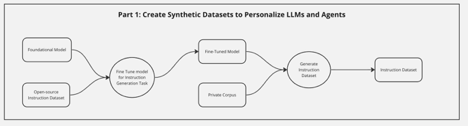

In [2]:
import langchain
import zipfile
import os
import collections
import pandas as pd

from langchain.document_loaders import UnstructuredWordDocumentLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

### Load documents from disk

In [3]:
with zipfile.ZipFile("R&I.zip", 'r') as zip_ref:
    zip_ref.extractall("R&I")

print("File successfully extracted.")

File successfully extracted.


In [4]:
!pip install unstructured --q
!pip install docx2txt --q
!pip install python-docx -q
!pip install openpyxl -q
!pip install pdfminer -q

In [5]:
!pip install pdfminer.six -q

In [6]:
# Specify the directory path
dir_path = './R&I/'

# Get a list of all file extensions in the directory and its subdirectories
file_exts = []
for root, dirs, files in os.walk(dir_path):
    for file in files:
        _, ext = os.path.splitext(file)
        file_exts.append(ext)

# Count the number of files for each file extension
file_ext_counts = collections.Counter(file_exts)

# Print a list of unique file extensions
unique_file_exts = list(file_ext_counts.keys())
print(unique_file_exts)


['.xlsx', '.docx', '.pptx', '.pdf', '.xlsm', '.doc', '.xlsb', '.xls', '.xltm', '.26 Shelf life Milks (ELN-DE-SOP-004)']


In [7]:
all_files_list = []

for root, dirs, files in os.walk(dir_path):
    for file in files:
        file_name = os.path.join(root, file)
        all_files_list.append(file_name)


print(f"Number of files in dir {len(all_files_list)}")

Number of files in dir 203


## Split the documents into chuncks that will be passed into the model

This is needed due to memory constraints, computational efficiency, and improved results. This approach can lead to better results by allowing the model to focus on specific content and avoid mixing different context within a single input. It's especially helpful for handling long documents that may challenge the model's ability to maintain context and coherence, and it's often employed during fine-tuning to ensure consistent input lengths
 

In [8]:
from langchain.document_loaders import DirectoryLoader, DataFrameLoader, UnstructuredPowerPointLoader, UnstructuredImageLoader, \
    UnstructuredMarkdownLoader, UnstructuredFileLoader, UnstructuredWordDocumentLoader, PyMuPDFLoader, PDFMinerLoader

In [9]:
def read_excel(file_path):
     # Read all sheets in the Excel file
    xls = pd.ExcelFile(file_path)

    # Store the data from all sheets
    all_data = {}

    # Iterate over each sheet and read its data
    for sheet_name in xls.sheet_names:
        # Read the current sheet into a DataFrame
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Store the DataFrame in the dictionary using sheet name as the key
        all_data[sheet_name] = df

    return all_data

In [10]:
%%time

file_type_list = ['pptx', 'docx', 'csv', 'jpg', 'png', 'md', 'txt', 'pdf']

document_list = []
unloaded_files_list = []

for file_name in all_files_list:
    if file_name.endswith(".pptx"):
        try:
            loader = UnstructuredPowerPointLoader(file_name)
            data = loader.load()
            document_list.extend(data) 
        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)

    elif file_name.endswith((".docx", ".doc")):
        try:
            loader = UnstructuredWordDocumentLoader(file_name)
            data = loader.load()
            document_list.extend(data) 
        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)

    elif file_name.endswith(".csv"):
        try:
            df_temp = pd.read_csv(file_name, header=0)

            loader = DataFrameLoader(df_temp, page_content_column = str(df_temp.columns[0]))
            data = loader.load()
            
            if len(data) > 0:
                for x in data:
                    x.metadata['source'] = file_name
                    
            document_list.extend(data) 
        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)
            
    elif file_name.endswith(".xlsx"):
        continue
        try:
            all_data = read_excel(file_name)

            for sheet_name, df_temp in all_data.items():
                try:
                    # print(list(df_temp.columns))
                    loader = DataFrameLoader(df_temp, page_content_column = str(df_temp.columns[0]))
                    data = loader.load()
                    
                    if len(data) > 0:
                        for x in data:
                            x.metadata['source'] = file_name
                    
                    document_list.extend(data) 
                except Exception as e:
                    print(f"Error loading sheet in excel {file_name}: {sheet_name} {e}")
                    unloaded_files_list.append(f"{sheet_name} {file_name}")

                    ## To Do
                    ## Try to convert to pdf and read it

        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)
            
            
    elif file_name.endswith((".png", ".jpg")):
        try:
            ## To Do: Work on Detectron2 that is stopping this from loading
            loader = UnstructuredImageLoader(file_name)
            data = loader.load()
            document_list.extend(data) 
        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)
            
    elif file_name.endswith(".md"):
        try:
            print(file_name)
            loader = UnstructuredMarkdownLoader(file_name)
            data = loader.load()
            document_list.extend(data) 
        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)
            
    elif file_name.endswith(".txt"):
        try:
            loader = UnstructuredFileLoader(file_name)
            data = loader.load()
            document_list.extend(data) 
        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)
            
    elif file_name.endswith(".pdf"):
        try:
            loader = PDFMinerLoader(file_name)
            data = loader.load()
            document_list.extend(data) 
        except Exception as e:
            print(f"Error loading {file_name}:  {e}")
            unloaded_files_list.append(file_name)
            
print(f"Loaded {len(document_list)} documents")
print(f"Unable to load {len(unloaded_files_list)} documents")

Error loading ./R&I/09. Country Specific/09. Country Specific/01. China/01. ELN/WD.02.02.20 UX Scorecard CN- TEMPLATE.pptx:  No module named 'pptx'
Error loading ./R&I/08. Category Specific/08. Category Specific/01. Core Milks/WD.22.01.07 GIANT Compositional guidelines.doc:  soffice command was not found. Please install libreoffice
on your system and try again.

- Install instructions: https://www.libreoffice.org/get-help/install-howto/
- Mac: https://formulae.brew.sh/cask/libreoffice
- Debian: https://wiki.debian.org/LibreOffice
Error loading ./R&I/03. Recipe Development/03. Recipe Development/01. Main Recipe Development/01. Vitamins & Minerals/WD.06.19.02 Premix development Training.pptx:  No module named 'pptx'
Error loading ./R&I/03. Recipe Development/03. Recipe Development/04. Compliance - Regulatory/WD.28.00.04 NN Tool_Training for PD.pptx:  No module named 'pptx'
Error loading ./R&I/07. Official PD Documents/07. Official PD Documents/01. PDS & LI/WD.16.01.03 PDS LI control docu

In [12]:
print(f"Loaded {len(document_list)} documents")
print(f"Unable to load {len(unloaded_files_list)} documents")

Loaded 110 documents
Unable to load 6 documents


In [13]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_documents(document_list)

len(texts)

709

In [14]:
print(texts[80].page_content)

Table 2. Summarizing the target R&D recommendation Bifidobacterium breve M-16V dosing for different products at the end of shelf-life and with a tolerable deviation of +/- 0.5 log (R&D Position paper of 31-01-2017).

Partially hydrolyzed proteins

The pHP product consists of 100% hydrolyzed whey proteins. No casein protein is present in these products. The hydrolysate should be produced according to the description in the relevant EGD (PD Manual WD.22.01.02). The IF protein target is 2.3 g/100 kcal at minimum of legislation. Range of EC legislation is 1.8-3.0 g/100 kcal. FO protein target is 2.4 g/100 kcal according to nutritional insights at moment of development of 123611 HA 2. Range of legislation is 2.25-3.5 g/100 kcal. Internally in PD, hydrolysates are designed with +/- 5 % tolerable deviation.

Extensively hydrolyzed proteins

The EHP product contains 100% hydrolyzed whey protein and no casein proteins.  The hydrolysate should be produced according to the description in the rele

### Load model and generate questions

In [15]:
import helper
import time
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import AutoPeftModelForCausalLM

helper.check_gpu_capacity()

GPU Information:
GPU 0:
  Total Memory: 23028 MB
  Free Memory: 19897 MB
  Used Memory: 2618 MB
GPU 1:
  Total Memory: 23028 MB
  Free Memory: 18367 MB
  Used Memory: 4148 MB
GPU 2:
  Total Memory: 23028 MB
  Free Memory: 18367 MB
  Used Memory: 4148 MB
GPU 3:
  Total Memory: 23028 MB
  Free Memory: 10661 MB
  Used Memory: 11854 MB


In [16]:
model_dir = "models/peft-llama-7-int4-instruct-generation-training"

# load base LLM model and tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(
    model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_dir)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Define your data
```
instruction_set = {
    "instruction": ["where do aliens come from", "This is a sample sentence.", "Another example."],
    "response": ["Space", "This is a sample sentence.", "Another example."]
}
```

In [17]:
instruction_set = {
    "instruction": [],
    "response": []
}

### Might take 1hr

In [51]:
%%time

for text in texts:
    the_text = text.page_content
    prompt = f"""### Instruction:
    Use the Input below to create an instruction, which could have been used to generate the input using an LLM. 

    {the_text}
    
    ### Response:
    """

    input_ids = tokenizer(prompt, return_tensors="pt", 
                                     # max_length=4000,
                                     truncation=True
                                    ).input_ids.cuda()
    # with torch.inference_mode():
    outputs = model.generate(input_ids=input_ids, max_new_tokens=100, 
                            do_sample=True, 
                             top_p=0.8, 
                             temperature=0.2
                                       )
    
    outputs = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]
    
    if "### Response:" in outputs:
        outputs = outputs.split("### Response:")[1]
    outputs = outputs.strip(' ').strip('\n')
    outputs = outputs.split('\n')[0].strip(' ')
    
    # input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
    # # with torch.inference_mode():
    # outputs = model.generate(input_ids=input_ids, max_new_tokens=200, do_sample=True, top_p=0.9,temperature=0.2)
    # generated_instruction = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]
    # generated_instruction = generated_instruction.split('\n')[0].strip()
    
    # print(f"#### Text:\n\n{the_text}\n")
    # print(f"#### Generated instruction:\n\n{generated_instruction?}")
    
    
    # print(f"Ground truth:\n{sample_ds['instruction']}")
    instruction_set["instruction"].append(outputs)
    instruction_set["response"].append(text.page_content)

CPU times: user 55min 20s, sys: 2min 5s, total: 57min 26s
Wall time: 57min 25s


### Save as dataset

In [53]:
from datasets import Dataset, load_from_disk

dataset = Dataset.from_dict(instruction_set)
dataset = dataset.filter(lambda x: x['instruction'] != '')
dataset




Filter:   0%|          | 0/709 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'response'],
    num_rows: 708
})

In [54]:
dataset.save_to_disk("generated-dataset/peft-llama-7-int4-instruct-generation")

Saving the dataset (0/1 shards):   0%|          | 0/708 [00:00<?, ? examples/s]

In [55]:

# Load the dataset from disk
dataset_loaded = load_from_disk("generated-dataset/peft-llama-7-int4-instruct-generation")

In [56]:
dataset_loaded

Dataset({
    features: ['instruction', 'response'],
    num_rows: 708
})

In [57]:
for instruction, response in zip(dataset_loaded['instruction'][50:60], dataset_loaded['response'][50:60]):
    print("### Instruction ###\n")
    print(instruction)
    print("\n### Response ###\n")
    print(response)

    print('-' * 30)

### Instruction ###

What clinical studies are linked to the eHP engine?

### Response ###

Clinical studies linked to the eHP engine

The eHP engine is linked to the clinical studies described below. This means that the engine that was tested in these clinical studies need to remain unaltered when these studies are used for communication of safety and efficacy of the eHP product.

Verwimp 1995: Hydrolysate only

Inclusion between 1990-1991. Clinical Study Report unavailable

Both Pepti and Pepti Junior resulted in normal growth

Both Pepti and Pepti Junior decreased allergic symptoms 

Giampietro 2001: Hydrolysate only

1998-1999. Clinical Study Report unavailable

A total of 97% of participating children diagnosed with CMA tolerated Pepti

Pepti can be considered safe for its intended use

Moro 2006: Hydrolysate + prebiotics

Inclusion between 2003-2005. Clinical Study Report unavailable

Cumulative incidence of atopic dermatitis in prebiotic group was significantly reduced during fi

### Use vicuna

In [16]:
model_dir = "models/peft-vicuna-int4-instruct-generation-training"

# load base LLM model and tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(
    model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_dir)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Define your data
```
instruction_set = {
    "instruction": ["where do aliens come from", "This is a sample sentence.", "Another example."],
    "response": ["Space", "This is a sample sentence.", "Another example."]
}
```

In [17]:
instruction_set = {
    "instruction": [],
    "response": []
}

### Might take 1hr

In [18]:
%%time

for text in texts:
    the_text = text.page_content
    prompt = f"""### Instruction:
    Use the Input below to create an instruction, which could have been used to generate the input using an LLM. 

    {the_text}
    
    ### Response:
    """

    input_ids = tokenizer(prompt, return_tensors="pt", 
                                     # max_length=4000,
                                     truncation=True
                                    ).input_ids.cuda()
    # with torch.inference_mode():
    outputs = model.generate(input_ids=input_ids, max_new_tokens=100, 
                            do_sample=True, 
                             top_p=0.8, 
                             temperature=0.2
                                       )
    
    outputs = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]
    
    if "### Instruction:" in outputs:
        outputs = outputs.split("### Instruction:")[1]
    elif "### Note:" in outputs:
        outputs = outputs.split("### Note:")[1]

    outputs = outputs.strip('\n').strip(' ')
    outputs = outputs.strip(' ').strip('\n')
    outputs = outputs.split('\n')[0].strip(' ')

    # print(f"Ground truth:\n{sample_ds['instruction']}")
    instruction_set["instruction"].append(outputs)
    instruction_set["response"].append(text.page_content)

CPU times: user 16min 49s, sys: 1min 55s, total: 18min 44s
Wall time: 18min 44s


In [19]:
# instruction_set

### Save as dataset

In [20]:
from datasets import Dataset, load_from_disk

dataset = Dataset.from_dict(instruction_set)
dataset = dataset.filter(lambda x: x['instruction'] != '')
dataset




Filter:   0%|          | 0/709 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'response'],
    num_rows: 709
})

In [21]:
dataset.save_to_disk("generated-dataset/peft-vicuna-int4-instruct-generation")

Saving the dataset (0/1 shards):   0%|          | 0/709 [00:00<?, ? examples/s]

In [26]:

# Load the dataset from disk
dataset_loaded = load_from_disk("generated-dataset/peft-vicuna-int4-instruct-generation")

In [27]:
dataset_loaded

Dataset({
    features: ['instruction', 'response'],
    num_rows: 709
})

In [29]:
for instruction, response in zip(dataset_loaded['instruction'][50:60], dataset_loaded['response'][50:60]):
    print("### Instruction ###\n")
    print(instruction)
    print("\n### Response ###\n")
    print(response)

    print('-' * 30)

### Instruction ###

What is the eHP engine?

### Response ###

Clinical studies linked to the eHP engine

The eHP engine is linked to the clinical studies described below. This means that the engine that was tested in these clinical studies need to remain unaltered when these studies are used for communication of safety and efficacy of the eHP product.

Verwimp 1995: Hydrolysate only

Inclusion between 1990-1991. Clinical Study Report unavailable

Both Pepti and Pepti Junior resulted in normal growth

Both Pepti and Pepti Junior decreased allergic symptoms 

Giampietro 2001: Hydrolysate only

1998-1999. Clinical Study Report unavailable

A total of 97% of participating children diagnosed with CMA tolerated Pepti

Pepti can be considered safe for its intended use

Moro 2006: Hydrolysate + prebiotics

Inclusion between 2003-2005. Clinical Study Report unavailable

Cumulative incidence of atopic dermatitis in prebiotic group was significantly reduced during first 6 months of life

Supple